In [120]:
import sys
import os

path = os.path.dirname(os.path.abspath("__file__"))
sys.path.insert(0, path + '/../')

from util.io import log_files
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [95]:
importlib.reload(log_files)

cartpole = log_files.get_event_arrays(
    '/home/florent/workspace/logs/05-07-21/CartPole-v0/',
    regex='*PER*/**',
    # tags=['eval_elbo', 'policy_evaluation_avg_rewards', 'distortion', 'rate'],
    tags_renaming={'eval_elbo': 'ELBO'},
    run_name='prioritized replay',
    event_name='Cartpole-v0')
cartpole = cartpole.append(
    log_files.get_event_arrays(
        '/home/florent/workspace/logs/05-07-21/CartPole-v0/',
        regex='*[!PER]*/**',
        # tags=['eval_elbo', 'policy_evaluation_avg_rewards', 'distortion', 'rate'],
        tags_renaming={'eval_elbo': 'ELBO'},
        run_name='uniform replay',
        event_name='CartPole-v0'))


/home/florent/PycharmProjects/vae_mdp/test/../util/io/log_files.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if event_name is not None:


In [96]:
cartpole

,step,value,tag,run,event
0,80,79.0,step,prioritized replay,Cartpole-v0
1,80,8.067559,loss,prioritized replay,Cartpole-v0
2,80,-3.7258332,ELBO,prioritized replay,Cartpole-v0
3,80,0.22534545,state_mse,prioritized replay,Cartpole-v0
4,80,0.43562585,reward_mse,prioritized replay,Cartpole-v0
...,...,...,...,...,...
2329670,1000000,12.0,mean_state_bits_used,uniform replay,CartPole-v0
2329671,1000000,0.24528958,t_1,uniform replay,CartPole-v0
2329672,1000000,0.067275524,t_2,uniform replay,CartPole-v0
2329673,1000000,0.00049508875,entropy_regularizer_scale_factor,uniform replay,CartPole-v0


In [97]:
cartpole['tag'].unique()

array(['step', 'loss', 'ELBO', 'state_mse', 'reward_mse', 'distortion',
       'rate', 'annealed_rate', 'entropy_regularizer', 'encoder_entropy',
       'marginal_encoder_entropy', 'transition_log_probs',
       'replay_buffer_frames', 'mean_state_bits_used', 't_1', 't_2',
       'entropy_regularizer_scale_factor', 'kl_annealing_scale_factor',
       'wis_exponent', 'policy_evaluation_avg_rewards', 'state_frequency'],
      dtype=object)

In [60]:
cartpole.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3521585 entries, 0 to 2329674
Data columns (total 5 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   step    int64 
 1   value   object
 2   tag     object
 3   run     object
 4   event   object
dtypes: int64(1), object(4)
memory usage: 161.2+ MB


# Prioritized experience replay vs. uniform experience replay

In [105]:
importlib.reload(log_files)

cartpole = log_files.get_event_arrays(
    '/home/florent/workspace/logs/05-07-21/CartPole-v0/',
    regex='*PER*/**',
    tags=['eval_elbo', 'policy_evaluation_avg_rewards', 'distortion', 'rate'],
    tags_renaming={'eval_elbo': 'ELBO'},
    run_name='prioritized replay',
    event_name='Cartpole-v0')
cartpole = cartpole.append(
    log_files.get_event_arrays(
        '/home/florent/workspace/logs/05-07-21/CartPole-v0/',
        regex='*[!PER]*/**',
        tags=['eval_elbo', 'policy_evaluation_avg_rewards', 'distortion', 'rate'],
        tags_renaming={'eval_elbo': 'ELBO'},
        run_name='uniform replay',
        event_name='CartPole-v0'))


In [106]:
cartpole.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379876 entries, 0 to 253567
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   step    379876 non-null  int64 
 1   value   379876 non-null  object
 2   tag     379876 non-null  object
 3   run     379876 non-null  object
 4   event   379876 non-null  object
dtypes: int64(1), object(4)
memory usage: 17.4+ MB


In [107]:
eval_elbo = cartpole[cartpole['tag'] == 'ELBO']
policy_eval_avg_rew = cartpole[cartpole['tag'] == 'policy_evaluation_avg_rewards']

In [108]:
eval_elbo

,step,value,tag,run,event
249,10000,3.059836,ELBO,prioritized replay,Cartpole-v0
501,10000,2.9340463,ELBO,prioritized replay,Cartpole-v0
753,20000,5.890865,ELBO,prioritized replay,Cartpole-v0
1005,30000,4.049207,ELBO,prioritized replay,Cartpole-v0
1257,40000,5.4279413,ELBO,prioritized replay,Cartpole-v0
...,...,...,...,...,...
252557,960000,-388.78583,ELBO,uniform replay,CartPole-v0
252809,970000,-69.19865,ELBO,uniform replay,CartPole-v0
253061,980000,-1057.0253,ELBO,uniform replay,CartPole-v0
253313,990000,-41.44227,ELBO,uniform replay,CartPole-v0


In [122]:
eval_elbo = eval_elbo.astype(dtype={'value': np.float32})

In [109]:
policy_eval_avg_rew

,step,value,tag,run,event
248,10000,22.7,policy_evaluation_avg_rewards,prioritized replay,Cartpole-v0
500,10000,25.3,policy_evaluation_avg_rewards,prioritized replay,Cartpole-v0
752,20000,19.3,policy_evaluation_avg_rewards,prioritized replay,Cartpole-v0
1004,30000,18.1,policy_evaluation_avg_rewards,prioritized replay,Cartpole-v0
1256,40000,25.2,policy_evaluation_avg_rewards,prioritized replay,Cartpole-v0
...,...,...,...,...,...
252556,960000,200.0,policy_evaluation_avg_rewards,uniform replay,CartPole-v0
252808,970000,200.0,policy_evaluation_avg_rewards,uniform replay,CartPole-v0
253060,980000,200.0,policy_evaluation_avg_rewards,uniform replay,CartPole-v0
253312,990000,200.0,policy_evaluation_avg_rewards,uniform replay,CartPole-v0


<AxesSubplot:xlabel='step', ylabel='value'>

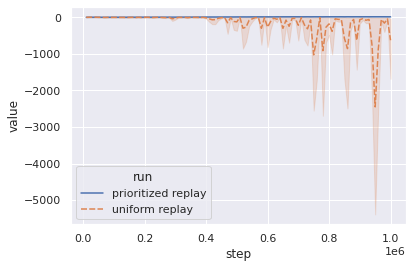

In [123]:
# fig, ax = plt.subplots()
#  eval_elbo.plot(title='eval elbo', ax=ax, grid=True)
#  policy_eval_avg_rew.plot(title='eval policy', ax=ax, grid=True)
sns.set_theme(style="darkgrid")
sns.lineplot(data=eval_elbo, x='step', y='value', style='run', hue='run')

TypeError: unhashable type: 'numpy.ndarray'

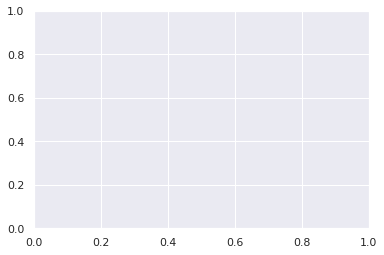

In [112]:
sns.lineplot(data=policy_eval_avg_rew, x='step', y='value', hue='run', style='run')

## State distribution histogram

In [103]:
importlib.reload(log_files)

hist = log_files.get_event_arrays(
    '/home/florent/workspace/logs/05-07-21/CartPole-v0/',
    regex='*PER*/**',
    tags=['state_frequency'],
    # tags_renaming={'eval_elbo': 'ELBO'},
    run_name='prioritized replay',
    event_name='Cartpole-v0')
hist = cartpole.append(
    log_files.get_event_arrays(
        '/home/florent/workspace/logs/05-07-21/CartPole-v0/',
        regex='*[!PER]*/**',
        tags=['state_frequency'],
        tags_renaming={'eval_elbo': 'ELBO'},
        run_name='uniform replay',
        event_name='CartPole-v0'))

In [104]:
hist

,step,value,tag,run,event
0,80,79.0,step,prioritized replay,Cartpole-v0
1,80,8.067559,loss,prioritized replay,Cartpole-v0
2,80,-3.7258332,ELBO,prioritized replay,Cartpole-v0
3,80,0.22534545,state_mse,prioritized replay,Cartpole-v0
4,80,0.43562585,reward_mse,prioritized replay,Cartpole-v0
...,...,...,...,...,...
1001,960000,"[[3.0, 139.3, 138233.0], [139.3, 275.6, 240.0]...",state_frequency,uniform replay,CartPole-v0
1002,970000,"[[3.0, 139.3, 130608.0], [139.3, 275.6, 251.0]...",state_frequency,uniform replay,CartPole-v0
1003,980000,"[[3.0, 139.3, 138041.0], [139.3, 275.6, 156.0]...",state_frequency,uniform replay,CartPole-v0
1004,990000,"[[3.0, 139.3, 125357.0], [139.3, 275.6, 143.0]...",state_frequency,uniform replay,CartPole-v0


In [101]:
cartpole[cartpole['tag'] == 'state_frequency'].value

2358       [[3.0, 139.3, 9078.0], [139.3, 275.6, 8442.0],...
4736       [[3.0, 139.3, 9025.0], [139.3, 275.6, 8360.0],...
7114       [[3.0, 139.3, 8982.0], [139.3, 275.6, 8403.0],...
9492       [[3.0, 139.3, 9035.0], [139.3, 275.6, 8498.0],...
11870      [[3.0, 139.3, 9038.0], [139.3, 275.6, 8560.0],...
                                 ...                        
2320644    [[3.0, 139.3, 138233.0], [139.3, 275.6, 240.0]...
2322897    [[3.0, 139.3, 130608.0], [139.3, 275.6, 251.0]...
2325150    [[3.0, 139.3, 138041.0], [139.3, 275.6, 156.0]...
2327403    [[3.0, 139.3, 125357.0], [139.3, 275.6, 143.0]...
2329656    [[3.0, 139.3, 136381.0], [139.3, 275.6, 195.0]...
Name: value, Length: 1507, dtype: object